# The elephant random walk

The one-dimensional ERW is defined as follows: The random walk starts at the origin at time zero,  $S_0=0$. At time $n=1$, the elephant moves up ($+1$) or down ($-1$) with equal probability. Hence, the position of the elephant at time $n=1$ is given by $S_1=X_1$ where $X_1$ has a Rademacher $\mathcal{R}(1/2)$ distribution. Afterwards, at any time $n \geq 1$, we choose indepdently and uniformly at random an integer $k$ among the previous times $1, \dots , n$ and we define 

\begin{align}
X_{n+1} := \begin{cases} + X_k & \text{with probability} & p, \\
-X_k & \text{with probability} & 1-p \end{cases}
\end{align}

where $p \in [0,1]$ is the memory of the ERW. Then, the position of the ERW is given by 
$$S_{n+1} = S_n + X_{n+1} $$

**Remark**: Observe that with our assumptions we have $\mathbb{E}(X_1)=0$.

**Remark**: Observe that in the setting of a SRRW we often introduce an independent sequence of Bernoulli($p$) random variables $( \varepsilon_n)_{n \geq 2}$ such that 
\begin{align}
X_{n+1} := \begin{cases} X_{n+1} & \text{if} & \varepsilon_n=0, \\
X_{U(n)} & \text{if} & \varepsilon_n=1 \end{cases}
\end{align}
where $U(n)$ is an independent uniform random variable on $\{1,2, \dots  , n\}$. However, for our purpose it is more elegant to translate $$ \mathbb{P}( \varepsilon_n = 1)=p = \mathbb{P}(U \leq p) $$ where $U$ is an independent (continuous) uniform random variable on $[0,1]$.

## Imports

In [ ]:
import torch  # PyTorch in order to have access to tensors and GPU computations
import numpy as np  # Maybe not necessary
import matplotlib.pyplot as plt  # For plotting

In [ ]:
(torch.cuda.is_available(), torch.cuda.get_device_name(0))  # Check if CUDA is available

(True, 'Tesla T4')

## Implement costum memory

For $\beta \in \mathbb{R}$ we want to work with the memory on $\{1,2, \dots ,  n\}$

$$ \mathbb{P}(J(n)=j) = \frac{j^\beta}{\sum_{i=1}^{n}i^\beta }, \qquad j=1,2, \dots ,  n. $$

Recall that for a discrete random variabe $X$, it's PMF (probability mass function) is given by $p_X: \mathbb{R} \to [0,1]$, with  $p_X(x)= \mathbb{P}(X = x) \in [0, 1]$ which uniquely characterises the law of $X$. Further, its CDF (cumulative distribution function) is defined as the monotone increasing function $F_X(x) = \mathbb{P}(X \leq x)$ and also uniquely determines the law of $X$. 

Concretely in our (discrete) setting we have for $x \in \{1,2, \dots , n\}$:

$$ F_J(x)= \mathbb{P}(J(n) \leq x) = \sum_{j=1}^x \mathbb{P}(J(n)=j) $$

**Inverse transform sampling** takes uniform samples of a number $u$ between zero and one and returns the smallest number $x \in \mathbb{R}$ such that $F_X(x) \geq u$ for the cumulative distribution function $F_X$ of a random variable. That is 

$$ F^{-1}(p) = \inf \{ x \in \mathbb{R} : F(x) \geq p \}, \qquad \text{for all } p \in [0,1]. $$

`torch.searchsorted` is a function that, for each element in the input tensor (we will use `uniform_samples`),  finds the index at which the element should be inserted into a sorted sequence (in our case, we will use `cdf`) to maintain the sorted order. The returned indices correspond to the elements in the original sequence (before calculating the CDF) associated with the probability of the sampled values. It is particularly useful when working with the cumulative distribution functions (CDFs) to generate samples from custom probability distribution.

In [ ]:
def custom_random_sampling(n, beta, size, seed=None, device='cpu'):
    """
    Custom random sampling function based on a power-law distribution.

    Input:
        - n: integer, the maximum value (exclusive) for the random samples
        - beta: float, the exponent of the power-law distribution
        - size: tuple of integers, shape of the output tensor
        - seed: (optional) Seed for reproducibility and testing purposes (int)
        - device: (optional) Target device for the computation (string, e.g., 'cpu' or 'cuda')

    Output:
        - samples: A tensor of shape `size` containing the sampled values (int)
    """

    # Set the random seed if specified
    if seed is not None:
        torch.manual_seed(seed)

    # Compute the probability mass function (pmf) using the power-law function
    pmf = torch.arange(1, n, dtype=torch.float32, device=device) ** beta

    # Normalize the pmf to make it a valid probability distribution
    pmf /= pmf.sum()

    # Compute the cumulative distribution function (cdf) from the pmf
    cdf = pmf.cumsum(dim = 0)

    # Generate uniform random samples between 0 and 1
    uniform_samples = torch.rand(size, device=device)

    # Convert uniform random samples to custom random samples using the cdf
    # the +1 is because Python uses 0-based indexing
    samples = torch.searchsorted(cdf, uniform_samples) + 1

    return samples



In [ ]:
## Sanity check

betas = [-10, -2, 0, 1, 5, 20]
max_value_n = 20
size = (1, 10)

for beta in betas:
    print(f"beta = {beta}: \n {custom_random_sampling(max_value_n, beta, size)}")

beta = -10: 
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
beta = -2: 
 tensor([[1, 2, 2, 1, 2, 2, 4, 3, 1, 1]])
beta = 0: 
 tensor([[ 9, 15, 13, 12,  4, 13,  7,  4, 13, 10]])
beta = 1: 
 tensor([[ 9, 19, 14, 10, 19,  7, 17, 15, 12, 11]])
beta = 5: 
 tensor([[18, 18, 19, 18, 18, 18, 16, 17, 19, 16]])
beta = 20: 
 tensor([[18, 19, 19, 19, 19, 19, 19, 19, 19, 19]])


## Implementation of the ERW 

Below we implement the ERW using the insight of Rüdiger Kürsten (see: https://arxiv.org/abs/1512.05275), there he describes that for $p \geq 1/2$ we can choose an uniform random $r$ between zero and one, if $r \leq p$ then the elephant does the same as it did in the past and if $r>p$ the elephant chooses at random (with equal probability) to go up ($+1$) or down ($-1$) independently on the past. This will then induce a SRRW with parameter $q=2p-1$ and since $p \geq 1/2$, we have $q \in [0, 1]$.

In [ ]:
def elephant_random_walk(num_steps : int, memory_strength : float, seed : int = None) -> list:
    """
    (Naive) sequential implementation of the ERW using a for loop.

    Input:  
            - num_steps: Number of steps for each walk (int)
            - memory_strength: Probability of returning to a previous position (float between 0 and 1)
            - seed (optional) for reproducibility and testing purposes only

    Output: 
            - steps (list/array) containing the steps of the ERW
    """

    # Set the random seed if specified
    if seed is not None:
        torch.manual_seed(seed)

    steps = torch.zeros(num_steps)  # Preallocate memory for output array


    # Iteratively generate the steps of the ERW
    for t in range(1, num_steps):
        # Choose to take a normal step or return to a previous position
        choice = torch.rand(1)  # uniform random choice in [0,1]

        if choice <= memory_strength and t > 1:
            # Choose uniformly at random a previous position from the memory
            idx = torch.randint(1, t, (1,))  # uniform random choice in {1, ..., t-1}
            steps[t] = steps[idx]    # repeat that step
        else:
            # Take an (independent) random step (-1 or 1)
            step = torch.randint(0, 2, (1,)) * 2 - 1  # Rademacher in {-1, +1}
            steps[t] =  step

    return steps

In [ ]:
elephant_random_walk(14, 0.3)

tensor([ 0., -1.,  1., -1.,  1., -1.,  1., -1., -1., -1.,  1., -1.,  1., -1.])

The implementation below is a vectorized implementation that should allow us to exploit the CUDA environment to work with GPU and **parallel computation**. Parallel computation is a type of computation in which multiple tasks or processes are executed simultaneously (i.e. in parallel), instead of sequentially (one after the other). The main goal of parallel computation is to improve the overall efficiency and performance of a system by dividing complex tasks into smaller subtasks and processing them concurrently.

In [ ]:
def batch_elephant_random_walk(num_walks, num_steps, memory_strength, beta = 0, seed=None, device='cpu'):
    """
    Batch implementation of the ERW for multiple independent walks.

    Input:
        - num_walks: Number of independent ERWs to process in parallel (int)
        - num_steps: Number of steps for each walk (int)
        - memory_strength: Probability of returning to a previous position (float between 0 and 1)
        - seed: (optional) Seed for reproducibility and testing purposes (int)
        - device: (optional) Target device for the computation (string, e.g., 'cpu' or 'cuda')

    Output:
        - steps: Tensor containing the steps of the ERWs (shape: [num_walks, num_steps])
    """

    # Set the random seed if specified
    if seed is not None:
        torch.manual_seed(seed)

    # (Preallocation): Initialize the steps tensor with zeros
    steps = torch.zeros(num_walks, num_steps, device=device)

    # Iterate over the time steps (starting from the second step)
    for t in range(1, num_steps):
        # Generate a random choice tensor for deciding between memory and normal moves
        choice = torch.rand(num_walks, device=device)

        # Determine which walks will perform a memory move and which will perform a normal move
        memory_move = (choice <= memory_strength) & (t > 1)  # Boolean tensor
        normal_move = ~memory_move  # All NOT memory moves.

        # Perform memory moves
        if memory_move.any():
            # Choose random previous steps for the memory moves
            # idx = torch.randint(1, t, (memory_move.sum().item(),), device=device)  
            idx = custom_random_sampling(t, beta, (memory_move.sum().item(),), seed=seed, device=device)
            # Update the steps of the memory moves
            steps[memory_move, t] = steps[memory_move, idx]

        # Perform normal moves
        if normal_move.any():
            # Generate random steps (-1 or 1) for the normal moves
            step = (torch.randint(0, 2, (normal_move.sum().item(),), device=device) * 2 - 1).float()
            # Update the steps of the normal moves based on the previous position and the step
            steps[normal_move, t] =  step

    return steps


In [ ]:
batch_elephant_random_walk(1, 13, 0.3, beta = 13, seed=None, device='cpu')

tensor([[ 0.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1.]])

## Visualisations

Below we gather some visualisations, for reasons of computational speed, we shall mainly work with the vectorized (batch) implementation of the ERW.

### Position of the ERW

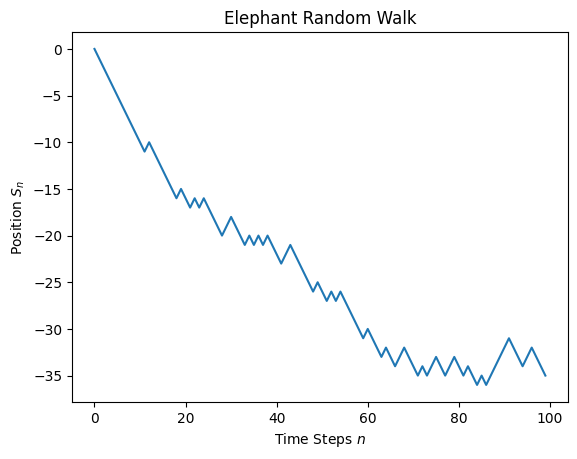

In [ ]:
num_steps = 100
memory_strength = 0.4  # this corresponds to p in the definition of the ERW.
random_walk = elephant_random_walk(num_steps, memory_strength)

# Visualize the random walk
plt.plot(random_walk.cumsum(dim = 0 )) 
plt.xlabel('Time Steps $n$')
plt.ylabel('Position $S_n$')
plt.title('Elephant Random Walk')
plt.show()

### LLN for the ERW

To visualize the Law of Large Numbers (LLN) for the ERW, we calculate and plot the running average of the position $S_n/n$ over time for multiple ERW simulations. If the LLN holds, you would expect the running average to converge to a constant value as the number of steps increases.

The code below generates a batch of ERWs on the GPU, calculates the running averages, and then plots them for a subset of the walks. **Note** that the plotting itself **is not** GPU-accelerated, as the GPU acceleration is primarily focused on the computational tasks.

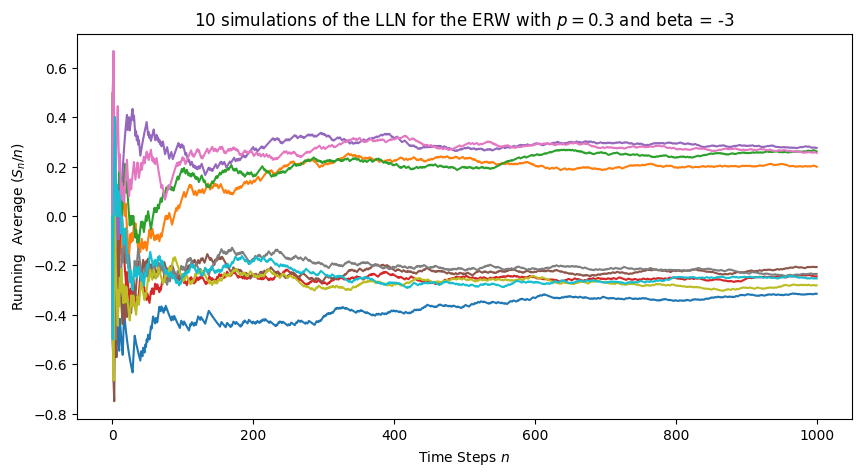

In [ ]:
num_walks = 1000
num_steps = 1000
memory_strength = 0.3
beta = -3

# Generate a batch of ERWs on the GPU
walks = batch_elephant_random_walk(num_walks, num_steps, memory_strength, beta, device='cuda')

# Calculate the cumulative sums of the steps (yields position) over time for each walk
cumulative_sums = torch.cumsum(walks, dim=1)

# Divide the cumulative sums by the number of steps to get the running averages
running_averages = cumulative_sums / torch.arange(1, num_steps + 1, device='cuda')

# Move the running averages tensor back to the CPU and convert it to a NumPy array
running_averages_np = running_averages.cpu().numpy()

# Plot the running averages for a subset of the walks
# Observe that for plotting we have no access to CUDA.
num_walks_to_plot = 10

plt.figure(figsize=(10, 5))

for i in range(num_walks_to_plot):
    plt.plot(running_averages_np[i])

plt.xlabel('Time Steps $n$')
plt.ylabel('Running  Average ($S_n/n$)')
plt.title(f'{num_walks_to_plot} simulations of the LLN for the ERW with $p=${memory_strength} and beta = {beta}' )
plt.show()


### CLT for ERW

The code below generates a batch of ERWs on the GPU, calculates the normalized cumulative sums, and then plots histograms for a selection of time steps. Note that the plotting itself is not GPU-accelerated, as the GPU acceleration is primarily focused on the computational tasks.

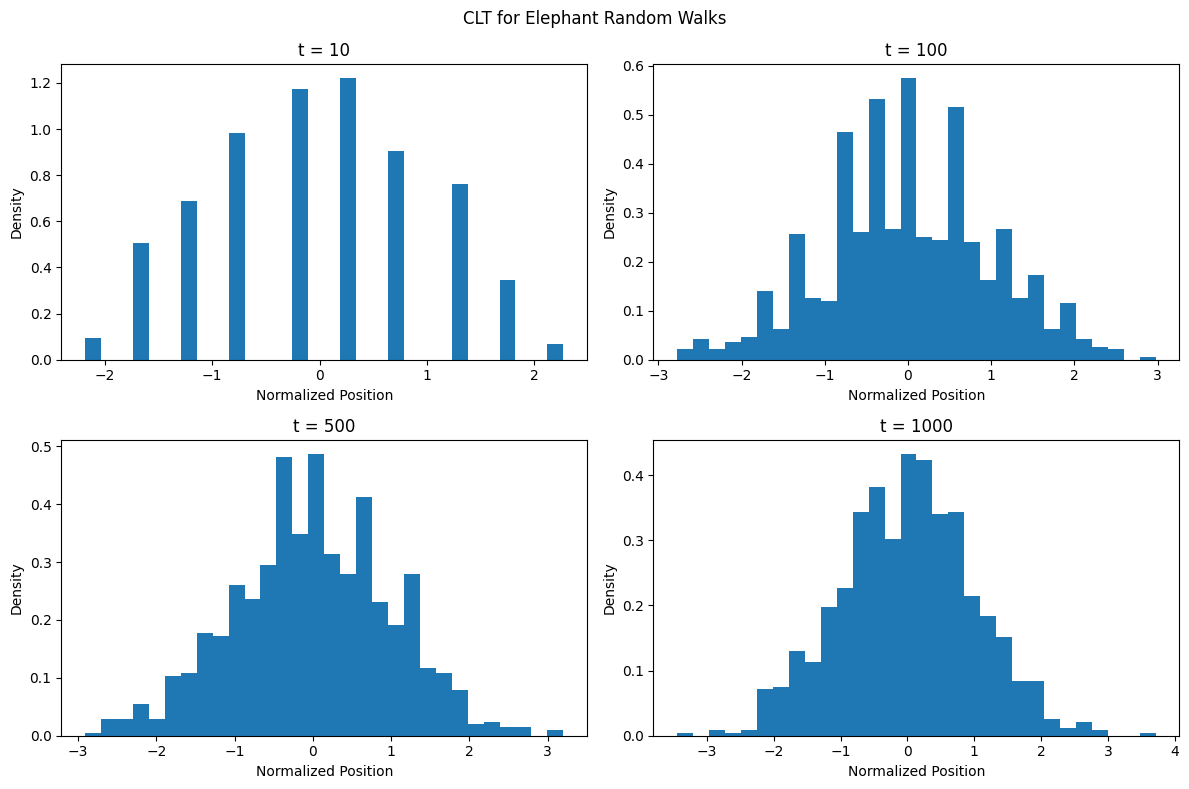

In [ ]:
num_walks = 1000
num_steps = 1000
memory_strength = 0.3
beta = 0

# Generate a batch of ERWs on the GPU
walks = batch_elephant_random_walk(num_walks, num_steps, memory_strength, beta, device='cuda')

# Calculate the cumulative sums of the steps (yields position) over time for each walk
cumulative_sums = torch.cumsum(walks, dim=1)

# Calculate the sample mean and sample variance for each time step
sample_mean = cumulative_sums.mean(dim=0)
sample_variance = cumulative_sums.var(dim=0)

# Normalize the cumulative sums by subtracting the sample mean and dividing by the square root of the sample variance
normalized_cumulative_sums = (cumulative_sums - sample_mean) / torch.sqrt(sample_variance)

# Move the normalized cumulative sums tensor back to the CPU and convert it to a NumPy array
normalized_cumulative_sums_np = normalized_cumulative_sums.cpu().numpy()

# Plot histograms of the normalized cumulative sums at different time steps
time_steps_to_plot = [10, 100, 500, 1000]

plt.figure(figsize=(12, 8))

for i, t in enumerate(time_steps_to_plot):
    plt.subplot(2, 2, i + 1)
    plt.hist(normalized_cumulative_sums_np[:, t - 1], bins=30, density=True)
    plt.title(f"t = {t}")
    plt.xlabel("Normalized Position")
    plt.ylabel("Density")

plt.suptitle("CLT for Elephant Random Walks")
plt.tight_layout()
plt.show()


The last picture gives a good visualisation of the result of Bernard Bercu (and others) that for $0 < p < 3/4$ we have  $$ \frac{S_n- \mathbb{E}(S_n)}{\sqrt{\sigma^2n}} \implies \mathcal{N} \left(0 , \frac{1}{3-4p} \right). $$

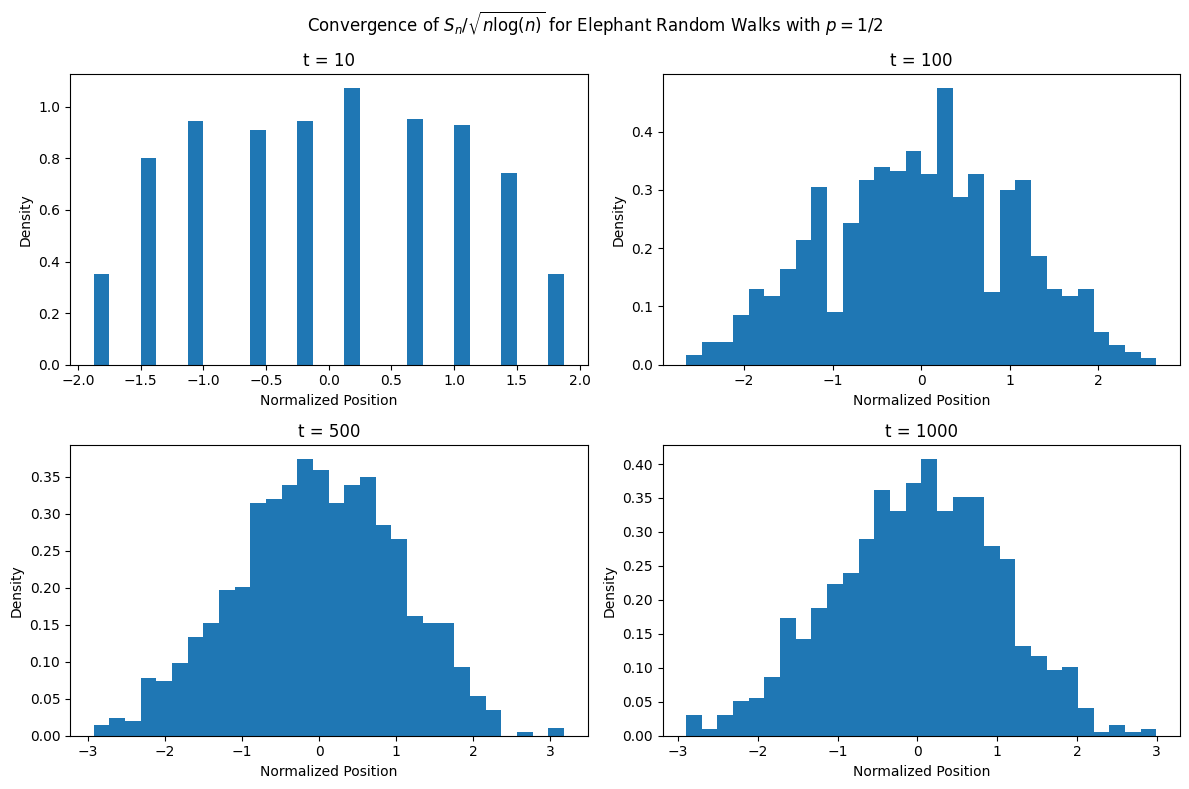

In [ ]:
num_walks = 1000
num_steps = 1000
memory_strength = 1/2
beta = 0

# Generate a batch of ERWs on the GPU
walks = batch_elephant_random_walk(num_walks, num_steps, memory_strength, beta, device='cuda')

# Calculate the cumulative sums of the steps (yielding position) over time for each walk
cumulative_sums = torch.cumsum(walks, dim=1)

# Calculate the normalization factors for each time step
normalization_factors = torch.sqrt(torch.arange(1, num_steps + 1, device='cuda') * torch.log(torch.arange(1, num_steps + 1, device='cuda')))

# Normalize the cumulative sums by dividing by the normalization factors
normalized_cumulative_sums = cumulative_sums / normalization_factors

# Move the normalized cumulative sums tensor back to the CPU and convert it to a NumPy array
normalized_cumulative_sums_np = normalized_cumulative_sums.cpu().numpy()

# Plot histograms of the normalized cumulative sums at different time steps
time_steps_to_plot = [10, 100, 500, 1000]

plt.figure(figsize=(12, 8))

for i, t in enumerate(time_steps_to_plot):
    plt.subplot(2, 2, i + 1)
    plt.hist(normalized_cumulative_sums_np[:, t - 1], bins=30, density=True)
    plt.title(f"t = {t}")
    plt.xlabel("Normalized Position")
    plt.ylabel("Density")

plt.suptitle("Convergence of $S_n / \sqrt{n \log(n)}$ for Elephant Random Walks with $p = 1/2$")
plt.tight_layout()
plt.show()


### Ballistic behaviour for $\beta < -1$

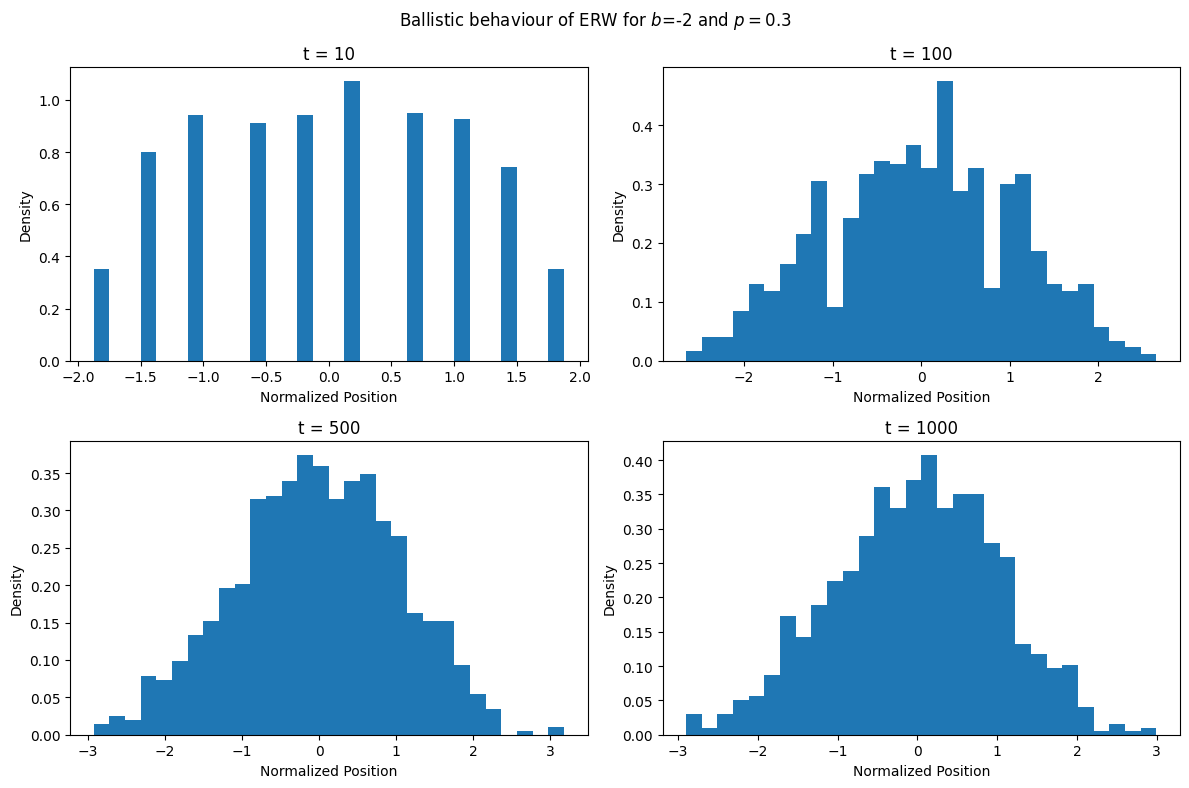

In [ ]:
num_walks = 1000
num_steps = 1000
memory_strength = 0.3
beta = -2

# Generate a batch of ERWs on the GPU
walks = batch_elephant_random_walk(num_walks, num_steps, memory_strength, beta, device='cuda')

# Calculate the cumulative sums of the steps (yielding position) over time for each walk
cumulative_sums = torch.cumsum(walks, dim=1)

# Calculate the normalization factors for each time step
normalization_factors = torch.arange(1, num_steps + 1, device='cuda')

# Divide the cumulative sums by the number of steps to get the running averages

running_averages = cumulative_sums / normalization_factors

# Move the normalized cumulative sums tensor back to the CPU and convert it to a NumPy array

running_averages = running_averages.cpu().numpy()

# Plot histograms of the normalized cumulative sums at different time steps
time_steps_to_plot = [10, 100, 500, 1000]

plt.figure(figsize=(12, 8))

for i, t in enumerate(time_steps_to_plot):
    plt.subplot(2, 2, i + 1)
    plt.hist(normalized_cumulative_sums_np[:, t - 1], bins=30, density=True)
    plt.title(f"t = {t}")
    plt.xlabel("Normalized Position")
    plt.ylabel("Density")

plt.suptitle(f"Ballistic behaviour of ERW for $b$={beta} and $p=${memory_strength}")
plt.tight_layout()
plt.show()



## Phase Transitions

The work of Laulin shows (for a related memory process) that 

- Diffusive regime $p < \frac{1 + 2 \beta}{2(1 + \beta)}$, then $$ \lim_{n \to \infty} n^{-1/2} S_n = \mathcal{N}(0, \sigma_\beta^2).$$

- Critical regime $p = \frac{1 + 2 \beta}{ 2(1+\beta)}$, then $$ \lim_{n \to \infty} ( n \log(n))^{-1/2} S_n = \mathcal{N}(0, ..)$$

- A superdiffusive regime $p> \frac{1 + 2 \beta}{2(1 + \beta)}$, then there exists a non-degenerate random variable $L$ such that $$ \lim_{n \to \infty} n^{-p(1 + \beta)} S_n = L $$